
<div class="alert alert-info" role="alert">
  <p>
    <b>Usage Guidelines</b>
  </p>

  <p>
    This lesson is part of the <b>DS Lab core curriculum</b>. For that reason, this notebook can only be used on your WQU virtual machine.
  </p>

  <p>
    This means:
    <ul>
      <li><span style="color: red">ⓧ</span> No downloading this notebook.</li>
      <li><span style="color: red">ⓧ</span> No re-sharing of this notebook with friends or colleagues.</li>
      <li><span style="color: red">ⓧ</span> No downloading the embedded videos in this notebook.</li>
      <li><span style="color: red">ⓧ</span> No re-sharing embedded videos with friends or colleagues.</li>
      <li><span style="color: red">ⓧ</span> No adding this notebook to public or private repositories.</li>
      <li><span style="color: red">ⓧ</span> No uploading this notebook (or screenshots of it) to other websites, including websites for study resources.</li>
    </ul>

  </p>
</div>


<font size="+3"><strong>2.5. Predicting Apartment Prices in Mexico City 🇲🇽</strong></font>

In [12]:
import warnings

import wqet_grader

warnings.simplefilter(action="ignore", category=FutureWarning)
wqet_grader.init("Project 2 Assessment")

<div class="alert alert-block alert-warning">
    <b>Note:</b> In this project there are graded tasks in both the lesson notebooks and in this assignment. Together they total 24 points. The minimum score you need to move to the next project is 22 points. Once you get 22 points, you will be enrolled automatically in the next project, and this assignment will be closed. This means that you might not be able to complete the last two tasks in this notebook. If you get an error message saying that you've already passed the course, that's good news. You can stop this assignment and move onto the project 3. 
</div>

In this assignment, you'll decide which libraries you need to complete the tasks. You can import them in the cell below. 👇

In [13]:
# Import libraries here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from glob import glob
from category_encoders import OneHotEncoder
from ipywidgets import interact, Dropdown, FloatSlider, IntSlider
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


# Prepare Data

## Import

**Task 2.5.1:** Write a `wrangle` function that takes the name of a CSV file as input and returns a DataFrame. The function should do the following steps:

1. Subset the data in the CSV file and return only apartments in Mexico City (`"Distrito Federal"`) that cost less than \$100,000.
2. Remove outliers by trimming the bottom and top 10\% of properties in terms of `"surface_covered_in_m2"`.
3. Create separate `"lat"` and `"lon"` columns.
4. Mexico City is divided into [15 boroughs](https://en.wikipedia.org/wiki/Boroughs_of_Mexico_City). Create a `"borough"` feature from the `"place_with_parent_names"` column.
5. Drop columns that are more than 50\% null values.
6. Drop columns containing low- or high-cardinality categorical values. 
7. Drop any columns that would constitute leakage for the target `"price_aprox_usd"`.
8. Drop any columns that would create issues of multicollinearity. 

<div class="alert alert-block alert-info">
<b>Tip:</b> Don't try to satisfy all the criteria in the first version of your <code>wrangle</code> function. Instead, work iteratively. Start with the first criteria, test it out with one of the Mexico CSV files in the <code>data/</code> directory, and submit it to the grader for feedback. Then add the next criteria.</div>

In [14]:
# Build your `wrangle` function
def wrangle(filepath):
    df = pd.read_csv(filepath)
     
    # Drop columns with misssing values greater than 50%
    for column in df.columns:
        if df[column].isnull().sum() > len(df)/2:
            df.drop(columns = [column], inplace = True)
            
    # Drop rows with empty values
    #df.dropna(inplace = True)
            
    # Subset data: Apartment in "Distrito Federal" that is less than $100,000.
    mask_loc = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_type = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100000
    df = df[mask_loc & mask_type & mask_price]
            
    # Subset removing outliers in surface_covered_in_m2
    lower, higher = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(lower, higher)
    df = df[mask_area]
    
    # Seperate and drop "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand = True).astype(float)
    df.drop(columns = ["lat-lon"], inplace = True)
    
    # Create "borough" feature from "place_with_parent_names"
    df["borough"] = df["place_with_parent_names"].str.split("|", expand = True)[1]
    df.drop(columns = ["place_with_parent_names"], inplace = True)
    
    # Drop categorical values with high or low cardinarlity 
    df.drop(columns = ["operation", "property_type", "currency", "properati_url"], inplace = True)
    
    # Drop leaky columns
    df.drop(columns = ["price", "price_aprox_local_currency", "price_per_m2"], inplace = True)
    
    # Non of the columns are co-linear
    
    return df

In [15]:
# Use this cell to test your wrangle function and explore the data
df = wrangle("data/mexico-city-real-estate-1.csv")
df

price_aprox_usd  surface_covered_in_m2        lat         lon  \
11           94022.66                   57.0  23.634501 -102.552788   
20           70880.12                   56.0  19.402413  -99.095391   
21           68228.99                   80.0  19.357820  -99.149406   
22           24235.78                   60.0  19.504985  -99.208557   
26           94140.20                   50.0  19.354219  -99.126244   
...               ...                    ...        ...         ...   
4596         73761.07                   85.0  19.375733  -99.139518   
4597         32165.09                   60.0  19.325608  -99.061120   
4598         81664.04                   90.0  19.441043  -99.175585   
4599         32770.99                   50.0  19.442796  -99.154915   
4605         26265.89                   59.0  19.484988  -99.111710   

                borough  
11        Benito Juárez  
20            Iztacalco  
21        Benito Juárez  
22         Azcapotzalco  
26             Coyoacán  
...                 ...  
4596      Benito Juárez  
4597         Iztapalapa  
4598     Miguel Hidalgo  
4599         Cuauhtémoc  
4605  Gustavo A. Madero  

[1101 rows x 5 columns]

In [16]:

wqet_grader.grade(
    "Project 2 Assessment", "Task 2.5.1", wrangle("data/mexico-city-real-estate-1.csv")
)

**Task 2.5.2:** Use glob to create the list `files`. It should contain the filenames of all the Mexico City real estate CSVs in the `./data` directory, except for `mexico-city-test-features.csv`.

In [17]:


files = glob("data/mexico-city-real-estate-*.csv")
files



['data/mexico-city-real-estate-5.csv',
 'data/mexico-city-real-estate-1.csv',
 'data/mexico-city-real-estate-2.csv',
 'data/mexico-city-real-estate-4.csv',
 'data/mexico-city-real-estate-3.csv']

In [18]:
wqet_grader.grade("Project 2 Assessment", "Task 2.5.2", files)

**Task 2.5.3:** Combine your `wrangle` function, a list comprehension, and `pd.concat` to create a DataFrame `df`. It should contain all the properties from the five CSVs in `files`. 

In [19]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5473 entries, 1 to 4622
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB
None


price_aprox_usd  surface_covered_in_m2        lat        lon  \
1          82737.39                   75.0  19.362690 -99.150565   
3          72197.60                   62.0  19.291345 -99.124312   
4          44277.72                   85.0  19.354987 -99.061709   
13         60589.45                   52.0  19.469681 -99.086136   
18         47429.08                   53.0  19.443592 -99.121407   

                borough  
1         Benito Juárez  
3               Tlalpan  
4            Iztapalapa  
13    Gustavo A. Madero  
18  Venustiano Carranza

In [20]:

wqet_grader.grade("Project 2 Assessment", "Task 2.5.3", df)

## Explore

**Task 2.5.4:** Create a histogram showing the distribution of apartment prices (`"price_aprox_usd"`) in `df`. Be sure to label the x-axis `"Price [$]"`, the y-axis `"Count"`, and give it the title `"Distribution of Apartment Prices"`. Use Matplotlib (`plt`).

What does the distribution of price look like? Is the data normal, a little skewed, or very skewed?

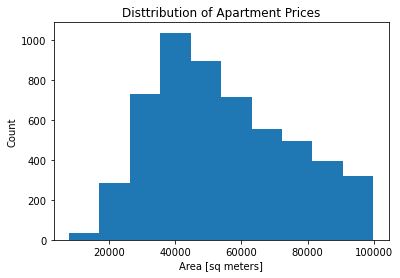

In [21]:


plt.hist(df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Count")
plt.title("Disttribution of Apartment Prices");

plt.savefig("images/2-5-4.png" , dpi = 150)


In [22]:
with open("images/2-5-4.png", "rb") as file:
    wqet_grader.grade("Project 2 Assessment", "Task 2.5.4", file)

**Task 2.5.5:** Create a scatter plot that shows apartment price (`"price_aprox_usd"`) as a function of apartment size (`"surface_covered_in_m2"`). Be sure to label your x-axis `"Area [sq meters]"` and y-axis `"Price [USD]"`. Your plot should have the title `"Mexico City: Price vs. Area"`. Use Matplotlib (`plt`).

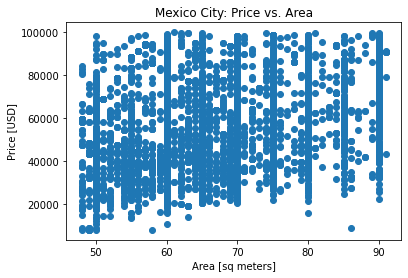

In [23]:
plt.scatter(x = df["surface_covered_in_m2"], y = df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Mexico City: Price vs. Area");


# Don't delete the code below 👇
plt.savefig("images/2-5-5.png", dpi=150)


Do you see a relationship between price and area in the data? How is this similar to or different from the Buenos Aires dataset?<span style='color: transparent; font-size:1%'>WQU WorldQuant University Applied Data Science Lab QQQQ</span>

In [24]:
with open("images/2-5-5.png", "rb") as file:
    wqet_grader.grade("Project 2 Assessment", "Task 2.5.5", file)

**Task 2.5.6:** **(UNGRADED)** Create a Mapbox scatter plot that shows the location of the apartments in your dataset and represent their price using color. 

What areas of the city seem to have higher real estate prices?

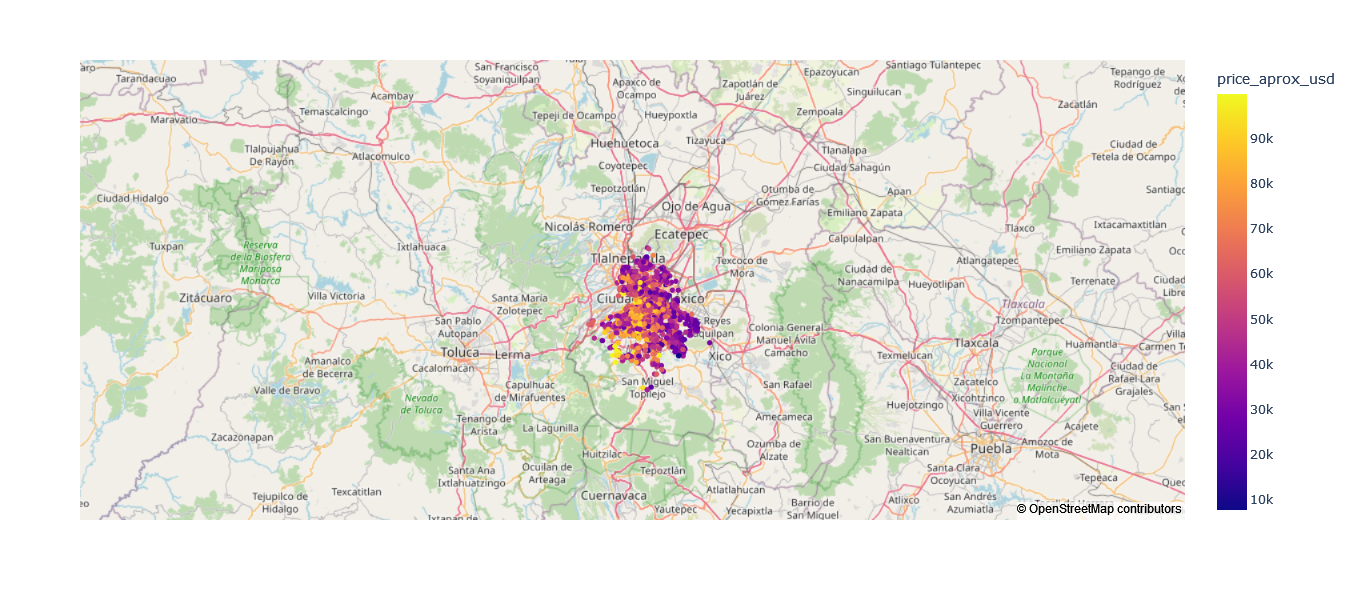

In [25]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,
    lat = "lat",
    lon = "lon",
    #center = {"lat": 19.6345, "lon": -99.5528},
    color = "price_aprox_usd",
    width = 900,
    height = 600,
    hover_data = ["borough", "surface_covered_in_m2", "price_aprox_usd"]
);

fig.update_layout(mapbox_style="open-street-map")
fig.show()

## Split

**Task 2.5.7:** Create your feature matrix `X_train` and target vector `y_train`. Your target is `"price_aprox_usd"`. Your features should be all the columns that remain in the DataFrame you cleaned above.

In [26]:


# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"
feature = []
for column in df.columns:
    if column != target:
        feature.append(column)
X_train = df[feature]
y_train = df[target]



In [27]:

wqet_grader.grade("Project 2 Assessment", "Task 2.5.7a", X_train)

In [28]:

wqet_grader.grade("Project 2 Assessment", "Task 2.5.7b", y_train)

# Build Model

## Baseline

**Task 2.5.8:** Calculate the baseline mean absolute error for your model.

In [29]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


In [30]:
wqet_grader.grade("Project 2 Assessment", "Task 2.5.8", [baseline_mae])

## Iterate

**Task 2.5.9:** Create a pipeline named `model` that contains all the transformers necessary for this dataset and one of the predictors you've used during this project. Then fit your model to the training data.

In [31]:


# Build Model
model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        SimpleImputer(),
        Ridge()
)
# Fit model
model.fit(X_train, y_train)



Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [32]:

wqet_grader.grade("Project 2 Assessment", "Task 2.5.9", model)

## Evaluate

**Task 2.5.10:** Read the CSV file `mexico-city-test-features.csv` into the DataFrame `X_test`.

<div class="alert alert-block alert-info">
<b>Tip:</b> Make sure the <code>X_train</code> you used to train your model has the same column order as <code>X_test</code>. Otherwise, it may hurt your model's performance.
</div>

In [33]:
X_test = pd.read_csv("data/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   float64
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(3), object(1)
memory usage: 32.7+ KB
None


surface_covered_in_m2        lat        lon        borough
0                   60.0  19.493185 -99.205755   Azcapotzalco
1                   55.0  19.307247 -99.166700       Coyoacán
2                   50.0  19.363469 -99.010141     Iztapalapa
3                   60.0  19.474655 -99.189277   Azcapotzalco
4                   74.0  19.394628 -99.143842  Benito Juárez

In [34]:

wqet_grader.grade("Project 2 Assessment", "Task 2.5.10", X_test)

**Task 2.5.11:** Use your model to generate a Series of predictions for `X_test`. When you submit your predictions to the grader, it will calculate the mean absolute error for your model.

In [35]:


y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()



0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

In [36]:
wqet_grader.grade("Project 2 Assessment", "Task 2.5.11", y_test_pred)

# Communicate Results

**Task 2.5.12:** Create a Series named `feat_imp`. The index should contain the names of all the features your model considers when making predictions; the values should be the coefficient values associated with each feature. The Series should be sorted ascending by absolute value.  

In [37]:


coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index = features)
feat_imp



surface_covered_in_m2               291.654156
lat                                 478.901375
lon                               -2492.221814
borough_Benito Juárez             13778.188880
borough_Tlalpan                   10319.429804
borough_Iztapalapa               -13349.017448
borough_Gustavo A. Madero         -6637.429757
borough_Venustiano Carranza       -5609.918629
borough_Iztacalco                   405.403127
borough_Coyoacán                   3737.561001
borough_Cuauhtémoc                 -350.531990
borough_Miguel Hidalgo             1977.314718
borough_Azcapotzalco               2459.288646
borough_Tláhuac                  -14166.869486
borough_Álvaro Obregón             3275.121061
borough_La Magdalena Contreras    -5925.666450
borough_Xochimilco                  929.857400
borough_Cuajimalpa de Morelos      9157.269123
dtype: float64

In [38]:

wqet_grader.grade("Project 2 Assessment", "Task 2.5.12", feat_imp)

**Task 2.5.13:** Create a horizontal bar chart that shows the **10 most influential** coefficients for your model. Be sure to label your x- and y-axis `"Importance [USD]"` and `"Feature"`, respectively, and give your chart the title `"Feature Importances for Apartment Price"`. Use pandas. 

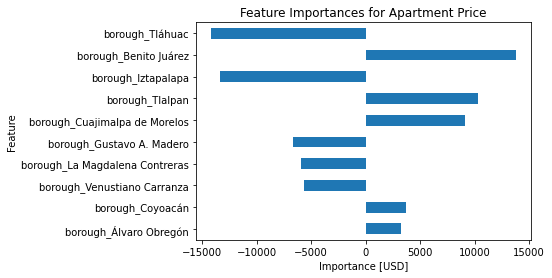

In [39]:


# Create horizontal bar chart
feat_imp.sort_values(key= abs).tail(10).plot(kind= "barh")




# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
# Add title
plt.title("Feature Importances for Apartment Price")

# Don't delete the code below 👇
plt.savefig("images/2-5-13.png", dpi=150)


In [40]:
with open("images/2-5-13.png", "rb") as file:
    wqet_grader.grade("Project 2 Assessment", "Task 2.5.13", file)

---
Copyright 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
